<a href="https://colab.research.google.com/github/otakunoichin/test/blob/main/AI%E7%B6%B2%E8%86%9C1m1y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os, re, glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

ROOT = "/content/drive/MyDrive/AiFundas"
ckpt_path = os.path.join(ROOT, "best_unet.pt")

pairs = [
    ("pt1_1M.png",   "pt1_1Y.png"),
    ("pt13R_1M.png", "pt13R_1Y.png"),
    ("pt21R_1M.png", "pt21R_1Y.png"),
    ("pt27R_1M.png", "pt27R_1Y.png"),
]

print("ckpt exists:", os.path.exists(ckpt_path), "size:", os.path.getsize(ckpt_path) if os.path.exists(ckpt_path) else None)
for a,b in pairs:
    print(a, os.path.exists(os.path.join(ROOT,a)), "|", b, os.path.exists(os.path.join(ROOT,b)))

Mounted at /content/drive
ckpt exists: True size: 31113227
pt1_1M.png True | pt1_1Y.png True
pt13R_1M.png True | pt13R_1Y.png True
pt21R_1M.png True | pt21R_1Y.png True
pt27R_1M.png True | pt27R_1Y.png True


In [2]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, base=32):
        super().__init__()
        self.enc1 = DoubleConv(in_ch, base)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(base, base*2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(base*2, base*4)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(base*4, base*8)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(base*8, base*16)

        self.up4 = nn.ConvTranspose2d(base*16, base*8, 2, stride=2)
        self.dec4 = DoubleConv(base*16, base*8)
        self.up3 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
        self.dec3 = DoubleConv(base*8, base*4)
        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.dec2 = DoubleConv(base*4, base*2)
        self.up1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.dec1 = DoubleConv(base*2, base)

        self.outc = nn.Conv2d(base, out_ch, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        b  = self.bottleneck(self.pool4(e4))

        d4 = self.up4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.outc(d1)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

ckpt = torch.load(ckpt_path, map_location=device)
state_dict = ckpt["model"]  # あなたの確認結果より

model = UNet(in_ch=1, out_ch=1, base=32).to(device)
model.load_state_dict(state_dict, strict=True)
model.eval()

print("loaded OK")

device: cuda
loaded OK


In [4]:
TARGET_SIZE = 4096
PATCH_SIZE  = 512

def load_gray_u8(path):
    return np.array(Image.open(path).convert("L"), dtype=np.uint8)

def reflect_pad_to(arr, target=4096):
    h, w = arr.shape
    if h > target or w > target:
        raise ValueError(f"image too large: {arr.shape} > {target}")
    pad_h = target - h
    pad_w = target - w
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left
    arr_pad = np.pad(arr, ((top, bottom), (left, right)), mode="reflect")
    return arr_pad, (top, bottom, left, right)

@torch.no_grad()
def predict_mask_from_image(gray_u8, thr=0.5):
    H, W = gray_u8.shape
    img_pad, (top, bottom, left, right) = reflect_pad_to(gray_u8, TARGET_SIZE)

    prob_canvas = np.zeros((TARGET_SIZE, TARGET_SIZE), dtype=np.float32)

    for r in range(TARGET_SIZE // PATCH_SIZE):
        for c in range(TARGET_SIZE // PATCH_SIZE):
            y0 = r * PATCH_SIZE
            x0 = c * PATCH_SIZE
            patch = img_pad[y0:y0+PATCH_SIZE, x0:x0+PATCH_SIZE].astype(np.float32) / 255.0

            x = torch.from_numpy(patch).unsqueeze(0).unsqueeze(0).to(device)
            logits = model(x)
            prob = torch.sigmoid(logits).squeeze().cpu().numpy()

            prob_canvas[y0:y0+PATCH_SIZE, x0:x0+PATCH_SIZE] = prob

    prob_crop = prob_canvas[top:top+H, left:left+W]
    mask01 = (prob_crop > thr).astype(np.uint8)
    return prob_crop, mask01

area 1M: 4540659 area 1Y: 3941255 ratio: 0.8679918487602771


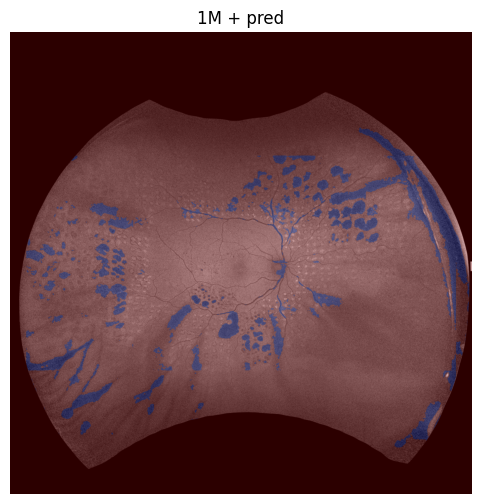

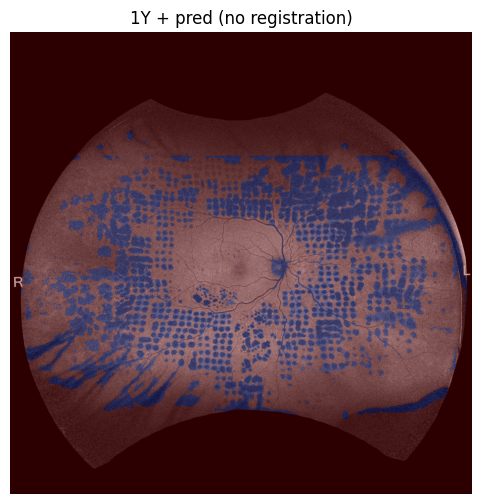

In [5]:
def area(mask01):
    return int(mask01.sum())

def show_overlay(img_u8, mask01, title=""):
    plt.figure(figsize=(6,6))
    plt.imshow(img_u8, cmap="gray")
    plt.imshow((mask01*255).astype(np.uint8), cmap="jet", alpha=0.35)
    plt.title(title)
    plt.axis("off")
    plt.show()

# 1例だけ
f1M, f1Y = pairs[0]
img1M = load_gray_u8(os.path.join(ROOT, f1M))
img1Y = load_gray_u8(os.path.join(ROOT, f1Y))

probM, maskM = predict_mask_from_image(img1M, thr=0.5)
probY, maskY = predict_mask_from_image(img1Y, thr=0.5)

print("area 1M:", area(maskM), "area 1Y:", area(maskY), "ratio:", area(maskY)/(area(maskM)+1e-8))

show_overlay(img1M, maskM, "1M + pred")
show_overlay(img1Y, maskY, "1Y + pred (no registration)")

{'case': 'pt1', 'ecc_cc': 0.9379669885098603, 'area_1M': 4540659, 'area_1Y': 4007281, 'area_delta': -533378, 'area_ratio': 0.8825329098705696}


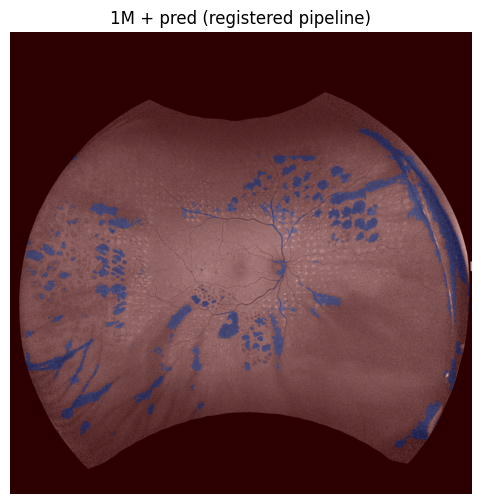

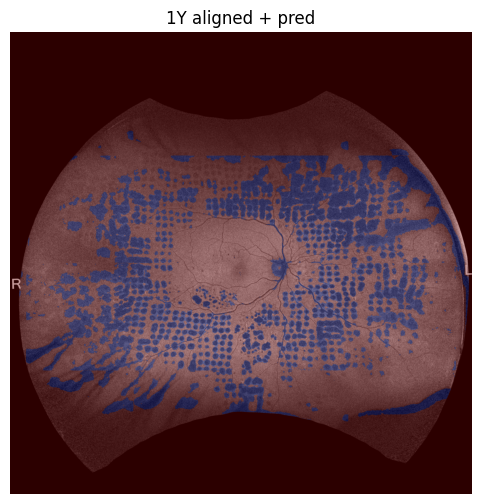

In [6]:
import cv2

def normalize_u8(img_u8):
    img = img_u8.astype(np.float32)
    mn, mx = np.percentile(img, 1), np.percentile(img, 99)
    img = np.clip(img, mn, mx)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    return (img*255).astype(np.uint8)

def register_ecc(ref_u8, mov_u8, warp_mode=cv2.MOTION_AFFINE, iters=300, eps=1e-6):
    ref_f = ref_u8.astype(np.float32)
    mov_f = mov_u8.astype(np.float32)

    if warp_mode == cv2.MOTION_HOMOGRAPHY:
        warp = np.eye(3, 3, dtype=np.float32)
    else:
        warp = np.eye(2, 3, dtype=np.float32)

    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, iters, eps)
    cc, warp = cv2.findTransformECC(ref_f, mov_f, warp, warp_mode, criteria)

    if warp_mode == cv2.MOTION_HOMOGRAPHY:
        aligned = cv2.warpPerspective(mov_u8, warp, (ref_u8.shape[1], ref_u8.shape[0]),
                                      flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    else:
        aligned = cv2.warpAffine(mov_u8, warp, (ref_u8.shape[1], ref_u8.shape[0]),
                                 flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    return aligned, warp, float(cc)

def summarize_one_pair(f1M, f1Y, thr=0.5, warp_mode=cv2.MOTION_AFFINE):
    img1M = load_gray_u8(os.path.join(ROOT, f1M))
    img1Y = load_gray_u8(os.path.join(ROOT, f1Y))

    ref = normalize_u8(img1M)
    mov = normalize_u8(img1Y)
    alignedY, warp, cc = register_ecc(ref, mov, warp_mode=warp_mode)

    # alignedYは正規化画像なので、同じwarpを「元のimg1Y」に適用
    if warp_mode == cv2.MOTION_HOMOGRAPHY:
        img1Y_aligned = cv2.warpPerspective(img1Y, warp, (img1M.shape[1], img1M.shape[0]),
                                            flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    else:
        img1Y_aligned = cv2.warpAffine(img1Y, warp, (img1M.shape[1], img1M.shape[0]),
                                       flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

    # セグ
    _, maskM = predict_mask_from_image(img1M, thr=thr)
    _, maskY = predict_mask_from_image(img1Y_aligned, thr=thr)

    A = area(maskM); B = area(maskY)
    return {
        "case": f1M.replace("_1M.png",""),
        "ecc_cc": cc,
        "area_1M": A,
        "area_1Y": B,
        "area_delta": B - A,
        "area_ratio": B/(A+1e-8),
        "img1M": img1M,
        "img1Y_aligned": img1Y_aligned,
        "maskM": maskM,
        "maskY": maskY
    }

# 1例確認
r = summarize_one_pair(pairs[0][0], pairs[0][1], thr=0.5, warp_mode=cv2.MOTION_AFFINE)
print({k:r[k] for k in ["case","ecc_cc","area_1M","area_1Y","area_delta","area_ratio"]})
show_overlay(r["img1M"], r["maskM"], "1M + pred (registered pipeline)")
show_overlay(r["img1Y_aligned"], r["maskY"], "1Y aligned + pred")

In [7]:
import pandas as pd

OUT_DIR = os.path.join(ROOT, "followup_compare")
os.makedirs(OUT_DIR, exist_ok=True)

def save_overlay(img_u8, mask01, out_path):
    rgb = np.stack([img_u8]*3, axis=-1)
    rgb[mask01==1] = [255,0,0]
    Image.fromarray(rgb.astype(np.uint8)).save(out_path)

rows = []
for f1M, f1Y in pairs:
    # 合わないときは homography にフォールバック
    try:
        r = summarize_one_pair(f1M, f1Y, thr=0.5, warp_mode=cv2.MOTION_AFFINE)
    except cv2.error:
        r = summarize_one_pair(f1M, f1Y, thr=0.5, warp_mode=cv2.MOTION_HOMOGRAPHY)

    rows.append({
        "case": r["case"],
        "file_1M": f1M,
        "file_1Y": f1Y,
        "ecc_cc": r["ecc_cc"],
        "area_1M": r["area_1M"],
        "area_1Y": r["area_1Y"],
        "area_delta": r["area_delta"],
        "area_ratio": r["area_ratio"],
    })

    save_overlay(r["img1M"], r["maskM"], os.path.join(OUT_DIR, f"{r['case']}_1M_overlay.png"))
    save_overlay(r["img1Y_aligned"], r["maskY"], os.path.join(OUT_DIR, f"{r['case']}_1Y_overlay.png"))

df = pd.DataFrame(rows).sort_values("case")
csv_path = os.path.join(OUT_DIR, "followup_change_summary.csv")
df.to_csv(csv_path, index=False)

print("saved:", csv_path)
df

saved: /content/drive/MyDrive/AiFundas/followup_compare/followup_change_summary.csv


,case,file_1M,file_1Y,ecc_cc,area_1M,area_1Y,area_delta,area_ratio
0,pt1,pt1_1M.png,pt1_1Y.png,0.937967,4540659,4007281,-533378,0.882533
1,pt13R,pt13R_1M.png,pt13R_1Y.png,0.956527,3820019,3365430,-454589,0.880998
2,pt21R,pt21R_1M.png,pt21R_1Y.png,0.924565,3531227,3695923,164696,1.046640
3,pt27R,pt27R_1M.png,pt27R_1Y.png,0.963204,3792793,3679762,-113031,0.970198
